# Estudo de modelos para séries temporais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

### Leitura dos dados

In [2]:
tserie = pd.read_csv('ribeiroGon.csv', index_col = 0).drop('data_ticks',1)

tserie = tserie[tserie['year'] >= 1988]

tserie['Data'] = pd.date_range('01-01-1988',periods=len(tserie), freq='MS')

tserie = tserie.set_index('Data')

#### Construção de histogramas e diagramas de dispersão

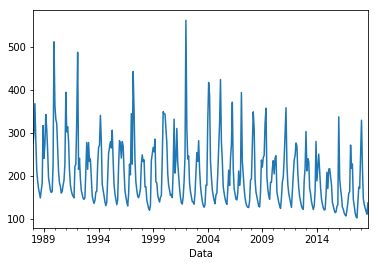

In [5]:
tserie['vazao'].plot();

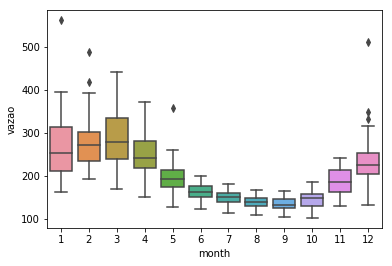

In [6]:
sns.boxplot(x= 'month', y= 'vazao', data = tserie);

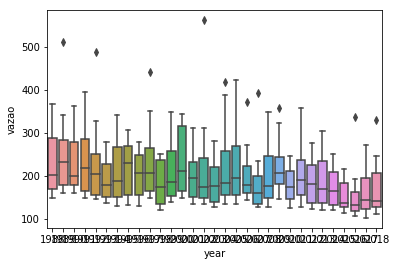

In [7]:
sns.boxplot(x= 'year', y= 'vazao', data = tserie);

### Distribuições

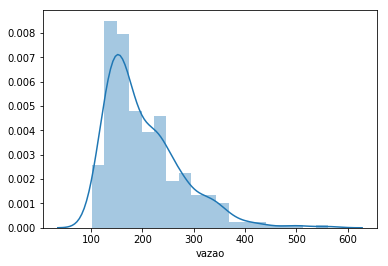

In [8]:
sns.distplot(tserie['vazao']);

In [23]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

/home/blamassa/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



CPU times: user 3min 11s, sys: 86 ms, total: 3min 11s
Wall time: 3min 13s


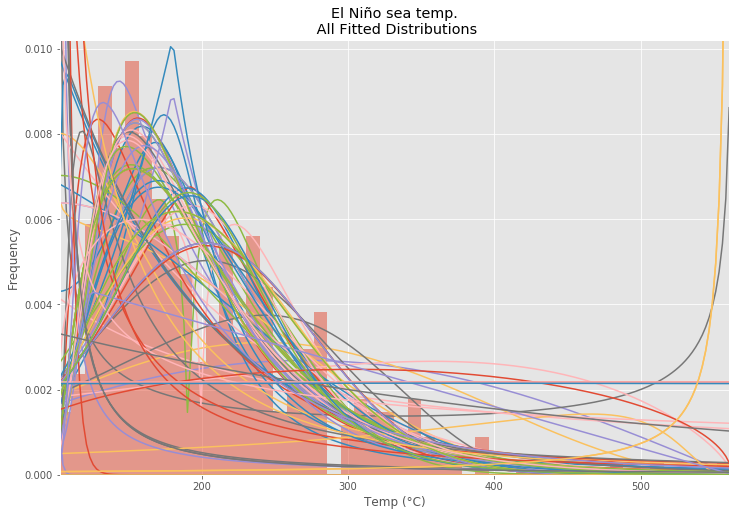

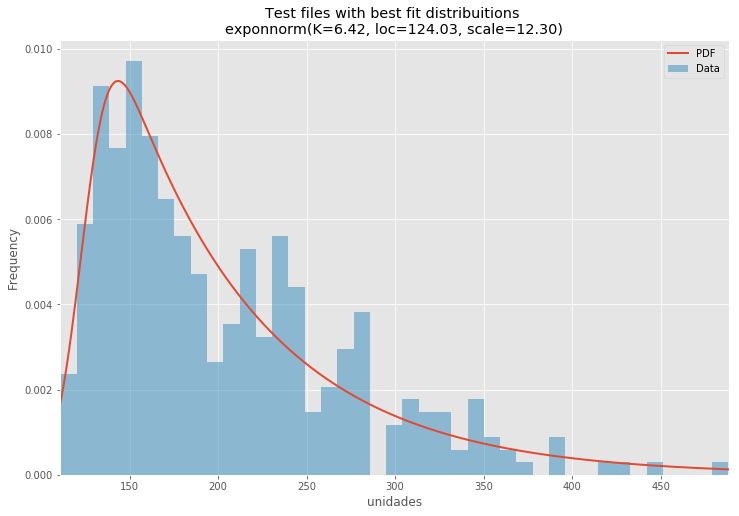

In [29]:
%%time

# Load data from statsmodels datasets
data = tserie.reset_index()['vazao']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u' All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Test files with best fit distribuitions \n' + dist_str)
ax.set_xlabel(u'unidades')
ax.set_ylabel('Frequency')

### Teste de Kolmogorov-Smirnov

In [41]:
from scipy import stats

In [47]:
param_str

'K=6.42, loc=124.03, scale=12.30'

In [49]:
best_fit_params

(6.4197393373441844, 124.02865190099365, 12.304223738369137)

In [65]:
sample_best_fit = stats.exponnorm.pdf(x = np.linspace(tserie['vazao'].min(),tserie['vazao'].max(), num=tserie['vazao'].count()),
                    K = best_fit_params[0],loc = best_fit_params[1],scale = best_fit_params[2])

In [70]:
sample_best_fit = stats.exponnorm.pdf(x = tserie['vazao'].values,
                    K = best_fit_params[0],loc = best_fit_params[1],scale = best_fit_params[2])

In [80]:
stats.ks_2samp(tserie['vazao'].values, pdf)

Ks_2sampResult(statistic=1.0, pvalue=1.14884582854e-313)

In [127]:
def empirical_cdf(sample, plotting=True):
    N = len(sample)
    rng = max(sample) - min(sample)
    if plotting:
        xs = np.concatenate([np.array([min(sample)-rng/3]), np.sort(sample) , np.array([max(sample)+rng/3])])
        ys = np.append(np.arange(N+1)/N, 1)
    else:
        xs = np.sort(sample)
        ys = np.arange(1, N+1)/N
    return (xs, ys)


In [135]:
n = 0
n_list = [0]

for i in range(len(pdf)):
    n += pdf.reset_index()[0][i]
    n_list.append(n_list)

In [ ]:
plt.step(pdf.index, pdf.values)
plt.step(*empirical_cdf(tserie['vazao'].values), where="post");

## Decomposição

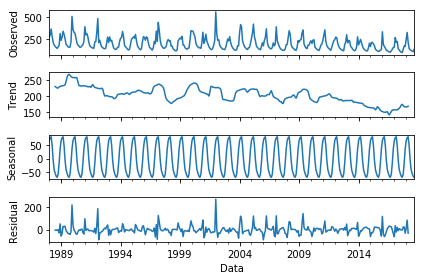

In [41]:
result = seasonal_decompose(tserie['vazao'])
result.plot()
plt.show()